In [1]:
# author: René Kopeinig
# script: Trends and cycles in cryptocurrency data
# description: Applying Arima and stochastic cycle model to demonstrate 
#              the difference of trend from cycle on cryptocurrency data from Quandl

In [2]:
# Add IPython-specific directive to display plots directly below the notebook cell
%matplotlib inline

In [1]:
# Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load BTC data 
btc = pd.read_csv('/home/rkopeinig/workspace/Time-Series-Analysis/data/btc.csv')
btc['date'] = pd.to_datetime(btc['date'])
btc = btc.set_index('date')
btc = btc['2017-06':'2017-09']

In [4]:
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(btc['price'], lamb=129600)

In [6]:
# Setting up Unobserved Components and ARIMA model
mod_uc_arima = sm.tsa.UnobservedComponents(btc['price'], 'rwalk', autoregressive=4)
res_uc_arima = mod_uc_arima.fit(method='powell', disp=False)
print(res_uc_arima.summary())

                        Unobserved Components Results                         
Dep. Variable:                  price   No. Observations:                  122
Model:                    random walk   Log Likelihood                -789.152
                              + AR(4)   AIC                           1590.305
Date:                Fri, 25 May 2018   BIC                           1607.129
Time:                        15:55:59   HQIC                          1597.138
Sample:                    06-01-2017                                         
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  1.347e+04   1.65e+04      0.814      0.415   -1.89e+04    4.59e+04
sigma2.ar     1.313e+04   1.64e+04      0.801 

In [7]:
# Setting up Unobserved components with stochastic cycle (UC)
mod_uc = sm.tsa.UnobservedComponents(btc['price'], 'rwalk',
                                     cycle=True, stochastic_cycle=True, damped_cycle=True)
res_uc = mod_uc.fit(method='powell', disp=False)
res_uc = mod_uc.fit(res_uc.params, disp=False)
print(res_uc.summary())

                            Unobserved Components Results                            
Dep. Variable:                         price   No. Observations:                  122
Model:                           random walk   Log Likelihood                -776.787
                   + damped stochastic cycle   AIC                           1561.574
Date:                       Fri, 25 May 2018   BIC                           1572.790
Time:                               15:56:09   HQIC                          1566.130
Sample:                           06-01-2017                                         
                                - 09-30-2017                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level     2.334e+04   2982.802      7.827      0.00

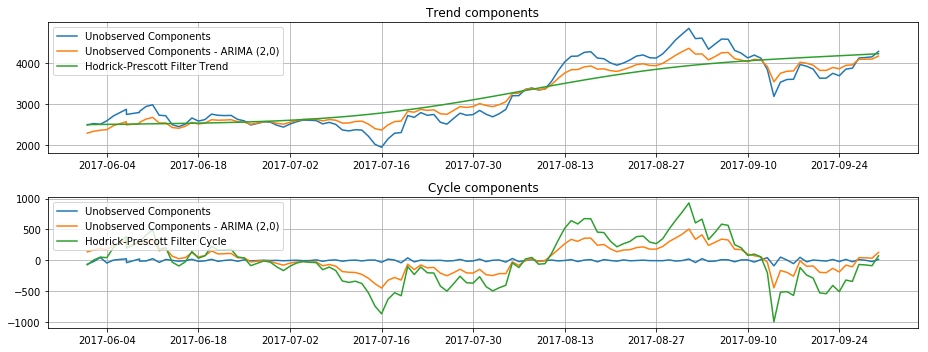

In [8]:
# Plot results
fig, axes = plt.subplots(2, figsize=(13,5));
axes[0].set(title='Trend components')
axes[0].plot(btc.index, res_uc.level.smoothed, label='Unobserved Components')
axes[0].plot(btc.index, res_uc_arima.level.smoothed, label='Unobserved Components - ARIMA (2,0)')
axes[0].plot(hp_trend, label='Hodrick-Prescott Filter Trend')
axes[0].legend(loc='upper left')
axes[0].grid()

axes[1].set(title='Cycle components')
axes[1].plot(btc.index, res_uc.cycle.smoothed, label='Unobserved Components')
axes[1].plot(btc.index, res_uc_arima.autoregressive.smoothed, label='Unobserved Components - ARIMA (2,0)')
axes[1].plot(hp_cycle, label='Hodrick-Prescott Filter Cycle')
axes[1].legend(loc='upper left')
axes[1].grid()

fig.tight_layout();

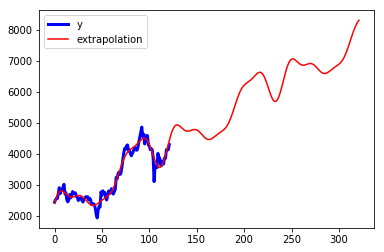

In [13]:
# Fourier Extrapolation
def fourierExtrapolation(series, n_predict=100):
    from numpy import fft
    n = series.size
    n_harm = 5
    t = np.arange(0, n)
    p = np.polyfit(t, series, 1)
    x_notrend = series - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

extrapolation = fourierExtrapolation(btc['price'], 200)
plt.plot(np.arange(0, btc['price'].values.size), btc['price'].values, 'b', label = 'y', linewidth = 3)
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
plt.legend()